FIIT STU v Bratislave, ZS 2019/2020, Utorok 11:00

---

# Projekt z predmetu Inteligentná analýza údajov
### Michal Heban, Ivana Frankovičová
Datasety č. 10

---

## 2. fáza - Predspracovanie

In [370]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb;
import re
import statistics as st
import statsmodels.api as sma
import statsmodels.stats as sms
import statsmodels.stats.api as smsa
from scipy import stats
from sklearn.impute import SimpleImputer

In [579]:
other_train = pd.read_csv("other_train.csv", sep=',', index_col = 0)

In [580]:
other_valid = pd.read_csv("other_valid.csv")

In [581]:
personal_train = pd.read_csv("personal_train.csv",sep=',', index_col = 0)

In [582]:
personal_valid = pd.read_csv("personal_valid.csv")

## Integrácia dát a prípadná deduplikácia záznamov

### Spojenie datasetov
Po spojení datasetov odstránime duplikáty podľa mena, adresy a dodatočne ešte aj veku (v prípade napríklad rodiča s dieťatom s rovnakou adresou je vek faktor, ktorý ich rozlíši), pričom však v niektorých riadkoch chýbajú údaje, ktoré ich duplikát má.
Pri deduplikácii bude teda potrebné zlúčiť informácie z duplicitných riadkov do jedného riadku.


In [583]:
finalDataset = pd.merge(other_train,personal_train, on=['name','address'], how='left')
duplicates = finalDataset[finalDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
finalDataset = finalDataset.drop_duplicates(['name', 'address'], keep=False)
names = duplicates.name.unique()

for name in names:
    tmp = duplicates[duplicates['name'] == name]
    tmp = tmp.fillna(method='ffill')
    tmp = tmp.fillna(method='bfill')
    tmp = tmp.drop_duplicates(['name'])
    finalDataset = finalDataset.append(tmp, ignore_index=True)

In [584]:
finalDataset.head(3)

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,age,sex,date_of_birth
0,Brian Newhall,"52925 Barton Ville Suite 664\r\nEast Whitney, ...",8.289889,f,14.0,Not-in-family,-0.378956,119.445312,17.929757,0.0,...,192702.0,0.0,53.143057,<=50K,2.932274,50.0,0.0,69,Female,50-06-08
1,Patrick Behne,"037 Long Springs\r\nPort Maria, OH 58969",4.322444,t,6.0,Husband,4.146348,77.085938,43.980061,0.0,...,211116.0,1.0,43.391932,<=50K,10.596154,40.0,0.0,59,Male,1960-07-28 00 00 00
2,Steven Arnold,"471 Kevin Spurs Suite 564\r\nReneeland, NC 84482",4.702130,f,5.0,Own-child,-0.170853,126.046875,36.950157,0.0,...,173736.0,0.0,50.909365,<=50K,7.939799,40.0,0.0,3500,Male,1984-08-04


### date_of_birth
V dalšej časti si upravíme dátumy na jednotný formát. Najprv si zistíme, aké všetky formáty sa v datasete nachádzajú, a to tak, že všetky čísla v dátume si nahradíme jednotným znakom, v našom prípade nulou.

In [585]:
dateFormats = finalDataset['date_of_birth'].str.replace('[0-9]', '0').value_counts()
dateFormats

0000-00-00             2605
0000-00-00 00:00:00     272
00-00-00                270
00/00/0000              263
0000-00-00 00 00 00     262
0000/00/00              261
Name: date_of_birth, dtype: int64

In [586]:
for format in dateFormats.index:
    dates = np.array(finalDataset[finalDataset['date_of_birth'].str.replace('[0-9]', '0') == format]['date_of_birth'].str.split('[-/ :]').tolist()).astype(np.int)
    print(format)
    print(np.max(dates, axis=0))
    print(np.min(dates, axis=0))

0000-00-00
[2020   12   31]
[1906    1    1]
0000-00-00 00:00:00
[1999   12   31    0    0    0]
[1934    1    1    0    0    0]
00-00-00
[96 12 31]
[5 1 1]
00/00/0000
[  31   12 2010]
[   1    1 1932]
0000-00-00 00 00 00
[2015   12   31    0    0    0]
[1939    1    1    0    0    0]
0000/00/00
[2012   12   31]
[1938    1    1]


Pre všetky formáty si vypíšeme maximálne a minimálne hodnoty, aby sme zistili, v akom poradí sú dni, mesiace a roky pri formáte 00-00-00 a zároveň môžeme odstrániť zo záznamov čas.

Môžeme si všimnúť, že najčastejšie používaný formát je YYYY-MM-DD, teda na tento formát sa budeme snažiť upraviť ostatné formáty, niekedy bude stačiť zmeniť oddeľovač, inokedy zmazať čas a v poslednom prípade zmeniť rok na celé číslo, nie len koncovku.

In [587]:
def dateFormat(date):
    dateForm = date.replace('1', '0')
    dateForm = dateForm.replace('2', '0')
    dateForm = dateForm.replace('3', '0')
    dateForm = dateForm.replace('4', '0')
    dateForm = dateForm.replace('5', '0')
    dateForm = dateForm.replace('6', '0')
    dateForm = dateForm.replace('7', '0')
    dateForm = dateForm.replace('8', '0')
    dateForm = dateForm.replace('9', '0')
    return dateForm

In [588]:
def changeDate(date):
    datef = dateFormat(date)
    if(datef == '00-00-00'):
        day = date[6:]
        month = date[:5]
        month = month[3:]
        year = date[:2]
        firstOfYear = year[:1]
        if(firstOfYear == '1' or firstOfYear == '0'):
            year ='20'+year
        else:
            year ='19'+year
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000-00-00 00:00:00'):
        date = date[:10]
        return date
    if(datef == '00/00/0000'):
        day = date[:2]
        month = date[:5]
        month = month[3:]
        year = date[6:]
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000/00/00'):
        date = date.replace('/','-')
        return date
    if(datef == '0000-00-00 00 00 00'):
        date = date[:10]
        return date
    if(datef == '0000-00-00'):
        return date
    else:
        print('no match')
        return date

In [589]:
finalDataset['date_of_birth'] = finalDataset['date_of_birth'].apply(changeDate)

In [590]:
dateFormats = finalDataset['date_of_birth'].str.replace('[0-9]', '0').value_counts()
dateFormats

0000-00-00    3933
Name: date_of_birth, dtype: int64

Po spustení funkcie už máme jednotný formát dátumu.

### pregnant
Máme 6 rôznych formátov pre údaje o tehotenstve, 3 pre true a 3 pre false, najviac záznamov používa formát t,f, tak ostatné záznamy prevedieme na tento formát zápisu.

In [591]:
finalDataset['pregnant'].value_counts()

f        3459
F         200
FALSE     188
t          81
T           3
TRUE        2
Name: pregnant, dtype: int64

In [592]:
def changePregnantInfoFlag(flag):
    if(flag == 'F'):
        return 'f'
    if(flag == 'FALSE'):
        return 'f'
    if(flag == 'T'):
        return 't'
    if(flag == 'TRUE'):
        flag = 't'
    if(flag == 't'):
        return 't'
    if(flag == 'f'):
        return 'f'

In [593]:
finalDataset['pregnant'] = finalDataset['pregnant'].apply(changePregnantInfoFlag)

In [594]:
finalDataset['pregnant'].value_counts()

f    3847
t      86
Name: pregnant, dtype: int64

Po vykonaní funkcie máme všetko v jednotnom formáte t,f.

### address

Odstránenie \r\n z adresy a nahradenie medzerou.

In [595]:
finalDataset['address'].head(1)

0    52925 Barton Ville Suite 664\r\nEast Whitney, ...
Name: address, dtype: object

In [596]:
def addressCorrection(address):
    address = address.replace('\r\n',' ')
    return address

In [597]:
finalDataset['address'] = finalDataset['address'].apply(addressCorrection)

In [598]:
finalDataset['address'].head(1)

0    52925 Barton Ville Suite 664 East Whitney, DC ...
Name: address, dtype: object

### personal_info

Použijeme funkciu z prvej fázy a rozdelíme atribút personal_info na viac atribútov.

In [832]:
def process_pi(text):
    if pd.isnull(text) or "undefined" in text:
        return pd.Series(["undefined"]*5)
    splitted_pi = re.split('[| \r\r\n]',text)
    splitted_pi = list(filter(None,splitted_pi))
    splitted_pi.remove("--")
    return pd.Series([splitted_pi[0],splitted_pi[1],splitted_pi[2],splitted_pi[3],splitted_pi[4]])

In [833]:
finalDataset[['job','state','family_status','home','color']] = finalDataset['personal_info'].apply(process_pi)

In [836]:
del finalDataset["personal_info"]

In [837]:
finalDataset.head(3)

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,...,hours-per-week,age,sex,date_of_birth,capital,job,state,family_status,home,color
0,Brian Newhall,"52925 Barton Ville Suite 664 East Whitney, DC ...",8.289889,f,14.0,Not-in-family,0.629342,119.445312,17.929757,4.428713,...,50.0,69,Female,1950-06-08,0,Craft-repair,United-States,Never-married,Private,White
1,Patrick Behne,"037 Long Springs Port Maria, OH 58969",4.322444,f,6.0,Husband,1.856560,77.085938,43.980061,3.012452,...,40.0,59,Male,1960-07-28,0,Other-service,United-States,Married-civ-spouse,Private,Black
2,Steven Arnold,"471 Kevin Spurs Suite 564 Reneeland, NC 84482",4.702130,f,5.0,Own-child,0.734519,126.046875,36.950157,3.160297,...,40.0,35,Male,1984-08-04,0,Machine-op-inspct,United-States,Never-married,Private,White


### sex 

Odstránenie medzery na začiatku slova.

In [17]:
def fixSex(sex):
    sex = sex.replace(' ','')
    return sex

In [600]:
finalDataset['sex'] = finalDataset['sex'].apply(fixSex)

#### Tehotní muži

Otestujeme možný problém, ktorý nám nenapadol počas prvej fázy projektu. Zistíme, či sa v datasete nachádzajú muži, ktorí sú podľa záznamu v datasete tehotní.

In [601]:
finalDataset['sex'].value_counts()

Male      2646
Female    1287
Name: sex, dtype: int64

In [602]:
test = finalDataset[finalDataset['pregnant'] == 't']
test = test[test['sex'] == 'Male']
test['sex'].count()

16

Máme 16 mužov, ktorí sú podľa datasetu tehotní. Upravíme tieto záznamy.

In [603]:
finalDataset.loc[(finalDataset["sex"] == 'Male') & (finalDataset["pregnant"] == 't') , 'pregnant'] = 'f'

In [604]:
test = finalDataset[finalDataset['pregnant'] == 't']
test = test[test['sex'] == 'Male']
test['sex'].count()

0

#### Následne sa pozrieme cez pairplot na numerické atribúty.

In [605]:
finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 24 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3932 non-null float64
pregnant            3933 non-null object
education-num       3933 non-null float64
relationship        3933 non-null object
skewness_glucose    3932 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3932 non-null float64
personal_info       3931 non-null object
education           3933 non-null object
fnlwgt              3931 non-null float64
class               3933 non-null float64
std_glucose         3933 non-null float64
income              3931 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3932 non-null float64
age               

In [606]:
columnsDiabetes = finalDataset[['kurtosis_oxygen','skewness_glucose','mean_glucose','std_oxygen','skewness_oxygen','kurtosis_glucose','std_glucose','mean_oxygen','class']]
columnsOthers = finalDataset[['education-num','capital-gain','fnlwgt','hours-per-week','capital-loss','age','class']]

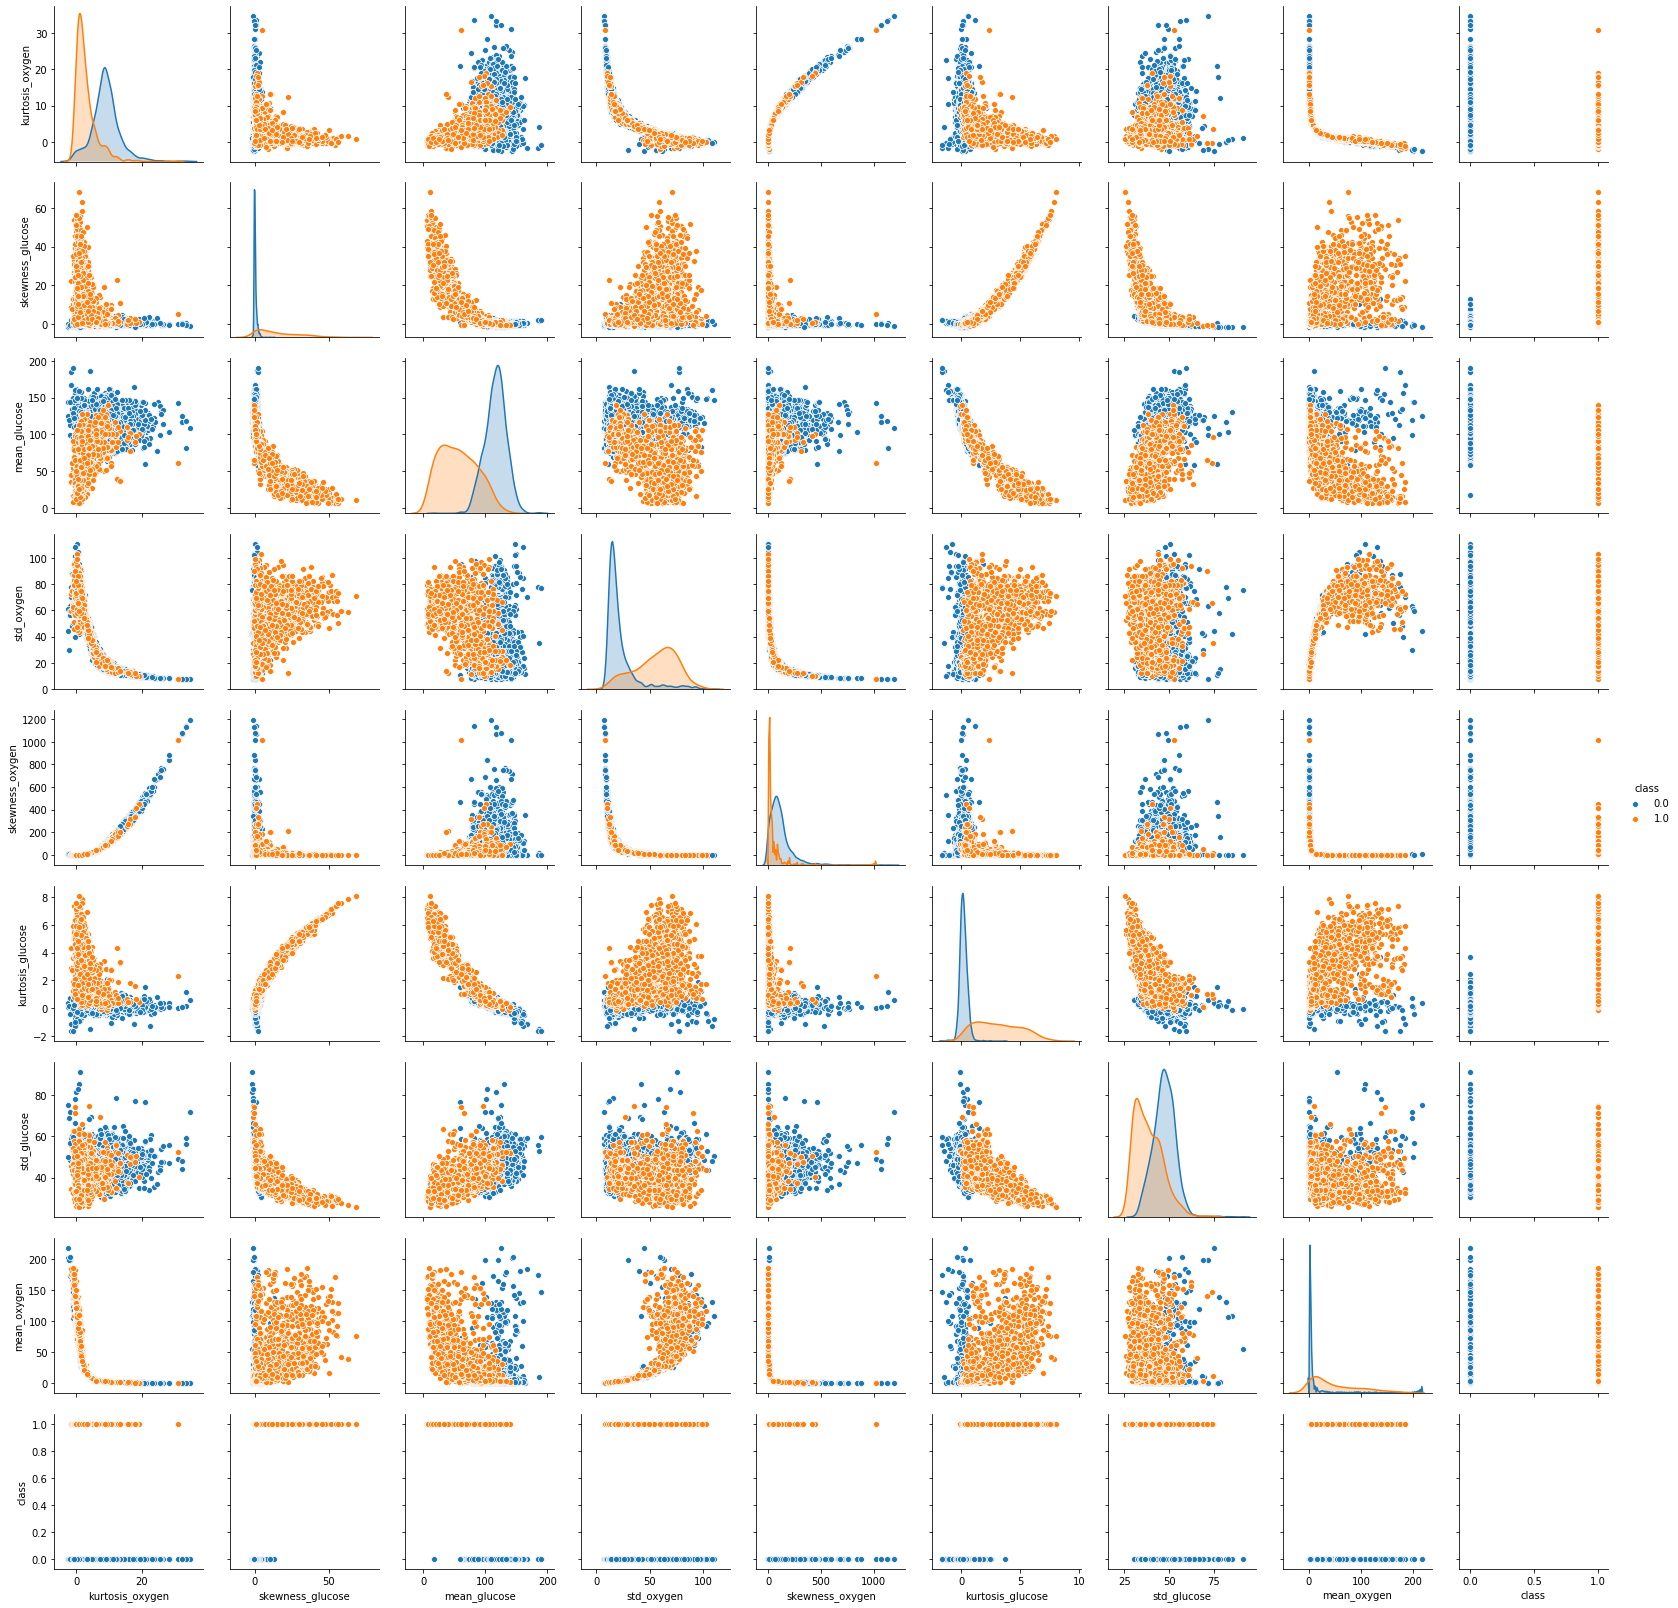

In [148]:
sb.pairplot(columnsDiabetes, hue='class')

Pri niektorých údajoch môžeme vidieť outlierov, ktorými sa budeme zaoberať neskôr.

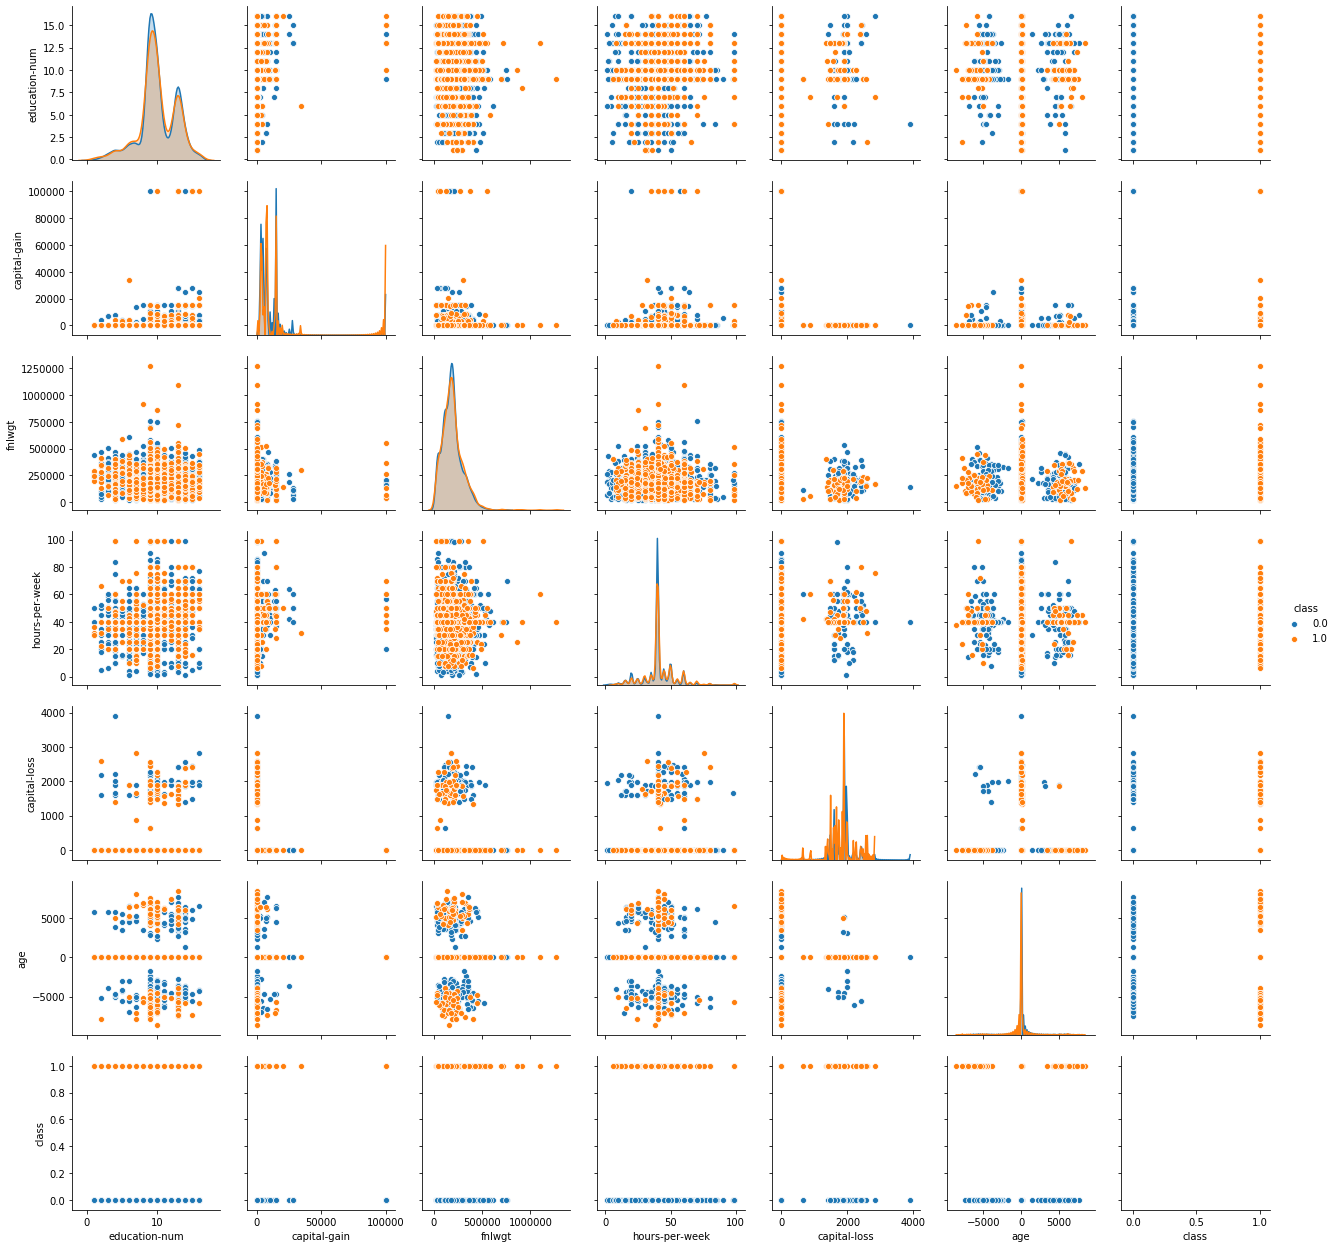

In [146]:
sb.pairplot(columnsOthers, hue='class')

Stĺpce capital-gain a capital-loss môžeme pre zjednodušenie zlúčiť do jedného stĺpca capital tak, že od stĺpca capital-gain odrátame hodnotu pri capital-loss.

In [607]:
finalDataset['capital'] = finalDataset['capital-gain'] - finalDataset['capital-loss']

In [608]:
del finalDataset["capital-gain"]
del finalDataset["capital-loss"]

##  Realizácia krokov predspracovania dát a ich zdokumentovanie


### Riešenie chýbajúcich hodnôt

In [609]:
finalDataset.isna().sum()

name                  0
address               0
kurtosis_oxygen       1
pregnant              0
education-num         0
relationship          0
skewness_glucose      1
mean_glucose        394
std_oxygen            0
skewness_oxygen       0
kurtosis_glucose      1
personal_info         2
education             0
fnlwgt                2
class                 0
std_glucose           0
income                2
mean_oxygen           0
hours-per-week        0
age                   0
sex                   0
date_of_birth         0
capital               1
dtype: int64

Po spojení atribútov nemáme veľké množstvo chýbajúcich záznamov, avšak najviac nám chýba pri jednom z najdôležitejších atribútov. Pre číselné atribúty, kde nám chýba do 10 záznamov použijeme strednú hodnotu, v opačnom prípade (pri atribúte mean_glucose) použijeme priemer segmentu.
Pre kategorické atribúty vytvoríme nový segment 'undefined', ak nebudeme schopní logicky prísť na to, čo daný záznam má obsahovať.

In [610]:
def setMissingValuesToMean(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean = imp_mean.fit(finalDataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [611]:
def setMissingValuesToMedian(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean = imp_mean.fit(finalDataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

Segment v našom prípade bude pohlavie.

In [612]:
def setMissingValuesToSegmentMean(dataset,column):
    meanMale = finalDataset[finalDataset['sex'] == 'Male'][column].mean()
    meanFemale = finalDataset[finalDataset['sex'] == 'Female'][column].mean()
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Male') , column] = meanMale
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Female') , column] = meanFemale

In [613]:
def setMissingValueToUndefined(dataset,column):
     dataset.loc[dataset[column].isna(), column] = 'undefined'

### kurtosis_oxygen

In [614]:
k = finalDataset[finalDataset['kurtosis_oxygen'].isna()]
k

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,...,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,age,sex,date_of_birth,capital
3890,Carl Crumpler,"136 Bennett Crescent North Jeremy, SD 72004",NaN,f,13.0,Husband,-0.386134,NaN,38.656632,11.830172,...,131463.0,0.0,53.360617,<=50K,11.18311,40.0,47,Male,1972-08-08,0.0


Na prvom atribúte si pre istotu spravíme kontrolu.

In [615]:
finalDataset['kurtosis_oxygen'][3890]

nan

In [616]:
mean =finalDataset['kurtosis_oxygen'].mean()
mean

7.414483362401841

In [617]:
setMissingValuesToMean(finalDataset,'kurtosis_oxygen')

In [618]:
finalDataset['kurtosis_oxygen'][3890]

7.414483362401831

Všeko vyzerá v poriadku, pre ostatné atribúty budeme iba volať funkciu na nastavenie hodnôt.

### skewness_glucose

In [619]:
setMissingValuesToMean(finalDataset,'skewness_glucose')

### mean_glucose
Na tento atribút použijeme nahradenie chýbajúcej hodnoty priemerom segmentu.

C:\Users\Nay\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Nay\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Nay\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Nay\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Skewness: -1.0389560856351583


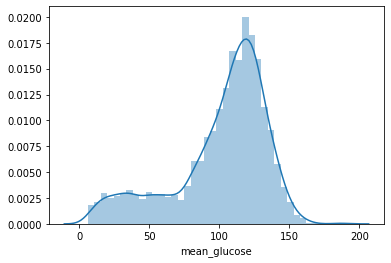

In [620]:
sb.distplot(finalDataset['mean_glucose'], bins=40)
print("Skewness:", finalDataset['mean_glucose'].skew())

In [621]:
setMissingValuesToSegmentMean(finalDataset,'mean_glucose')

Skewness: -1.095297065302652


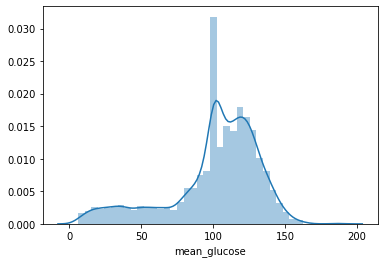

In [622]:
sb.distplot(finalDataset['mean_glucose'], bins=40)
print("Skewness:", finalDataset['mean_glucose'].skew())

Po použití funkcie na doplnenie chýbajúcich záznamov sa nám skewness trochu zhoršila, ale nie je to veľký rozdiel. Pri ostatných atribútoch grafy nie sú, pretože doplnenie jednej alebo dvoch hodnôt by bolo nepostrehnuteľné.

### kurtosis_glucose

In [623]:
setMissingValuesToMean(finalDataset,'kurtosis_glucose')

### fnlwgt
Tento údaj veľmi význam nemá, ale doplníme mu tam hodnotu mediánu.

In [625]:
setMissingValuesToMedian(finalDataset,'fnlwgt')

### income a capital
Nemáme ako zistiť príjmy daných osôb, teda chýbajúce hodnoty nastavíme na 'undefined'.

In [626]:
setMissingValueToUndefined(finalDataset,'income')

In [627]:
setMissingValueToUndefined(finalDataset,'capital')

In [628]:
finalDataset.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
skewness_oxygen     0
kurtosis_glucose    0
personal_info       0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
age                 0
sex                 0
date_of_birth       0
capital             0
dtype: int64

###  Riešenie vychýlených hodnôt - outlierov

Na riešenie vychýlených hodnôt si pripravíme zopár funkcií - na odstránenie vychýlených pozorovaní, na nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia, na transformáciu atribútu s vychýlenými hodnotami pomocou zvolenej funkcie. Pre každý atribút otestujeme, ktorá metóda je pre neho najvhodnejšia a danú metódu aplikujeme. Výnimkou bude atribút age, pre ktorý sme našli iné riešenie.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9D046BC18>,
      dtype=object)

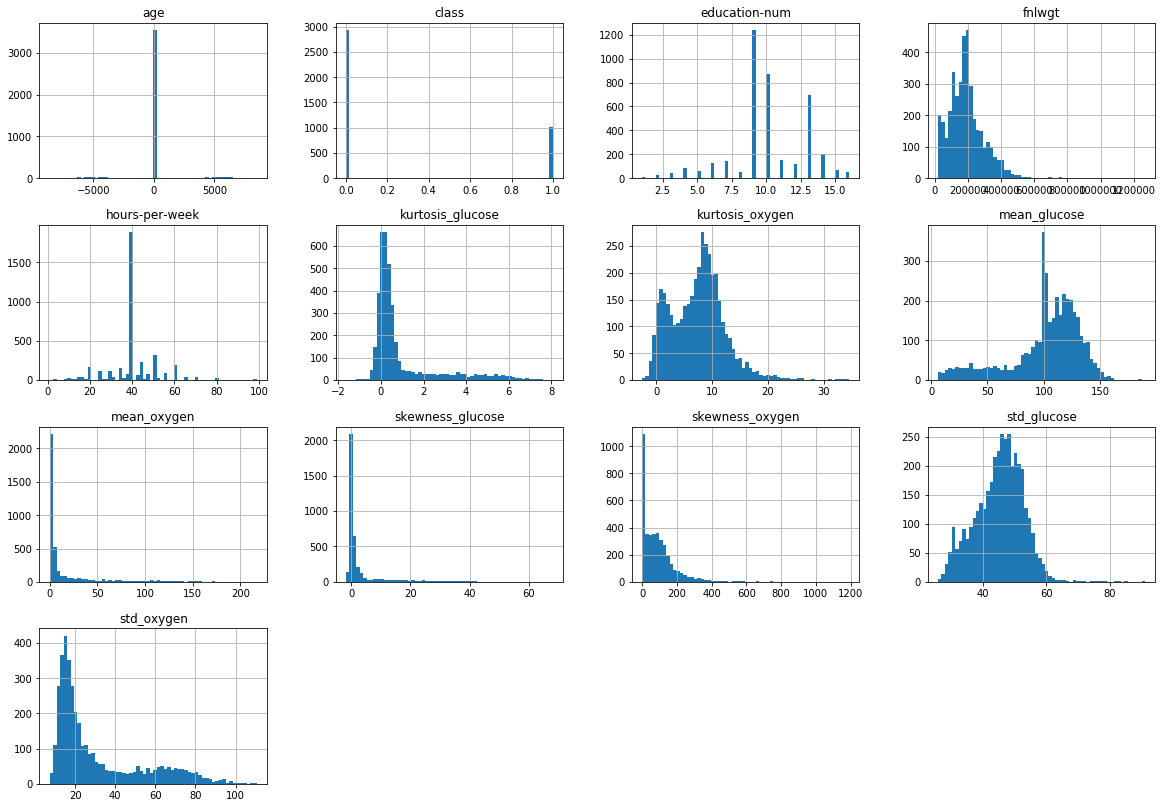

In [629]:
finalDataset.hist(figsize=(20, 14), bins=60)

### age

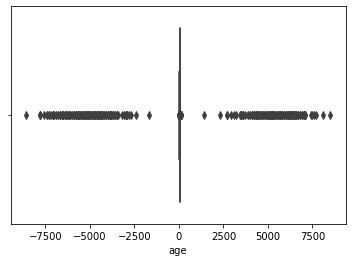

In [630]:
sb.boxplot(personal_train['age'])

V datasete sme spozorovali roky ľudí, ktoré nemali zmysel. Bližšie sa pozrieme na to, ako táto chyba mohla vzniknúť.

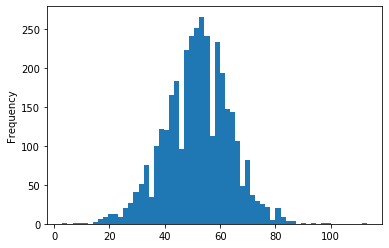

In [631]:
finalDataset[(finalDataset["age"] > 0) & (finalDataset["age"] < 150)]["age"].plot.hist(bins=60)

Tento histogram je graf z rokov ľudí, ktoré majú zmysel (0 až 150). Porovnáme jeho rozdelenie s grafmi pre roky menšie ako 0 a potom pre väčšie ako 150.

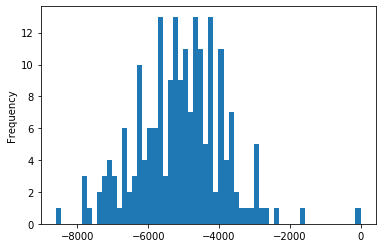

In [632]:
finalDataset[finalDataset["age"] < 0]["age"].plot.hist(bins=60)

Vykreslili sme si histogram rokov menších ako nula. Vidíme, že rozdelenie je podobné predchádzajúcemu grafu pre roky, ktoré majú zmysel. Vyzerá to ale tak, že je zrkadlovo otočené.

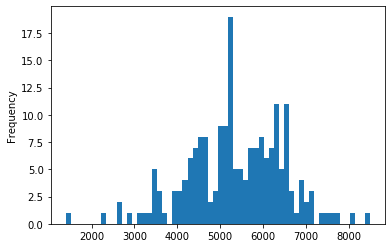

In [633]:
finalDataset[finalDataset["age"] > 150]["age"].plot.hist(bins=60)

Vykreslili sme si histogram rokov väčších ako 150. Vidíme, že aj toto rozdelenie je veľmi podobné grafu pre roky, ktoré majú zmysel.

Z týchto rozdelení grafov sme usúdili, že vek niektorých ľudí bol vynásobený 100 a niekedy v zápornom čísle, čo jednoduchou funkciou môžeme upraviť, takže pre daný atribút neodstránime outlierov, ani ich nebudeme rátať iným spôsobom, pretože to by nám dáta iba skreslilo.

In [634]:
def repair_age(age):
    if pd.isnull(age):
        return pd.Series(np.nan)
    if age >= 130:
        return int(age / 100)
    if age < 0:
        return int(((age * -1) / 100))
    else:
        return int(age)

In [635]:
finalDataset['age'] = finalDataset['age'].apply(repair_age)

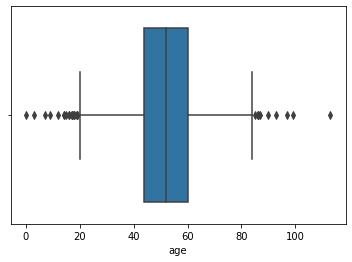

In [636]:
sb.boxplot(finalDataset['age'])

Môžeme vidieť, že v novom datasete po vykonaní funkcie na úpravu veku sa už nenachádzajú nezmyselné roky.

Atribúty class, education-num neriešime, pretože môžeme vidieť, že obsahujú normálne hodnoty už z grafu, hodnotu fnlgwt neriešime, pretože je to nepodstatný parameter a stĺpec gain sme už vyriešili vyššie, takže jemu sa už tiež venovať nebudeme, aj keď tam je jedna hodnota, ktorú si môžeme všimúť, že je určite outlier, no pre príjem peňazí nemôžeme povedať, že by tá hodnota bola nereálna, preto ju nebudeme riešiť.

Poďme sa pozrieť na ostatné. Ako prvé odstránime hodnoty nan, vypočítame si outlierov a následne ich odstránime, pričom ich neskôr nahradíme zmysluplnejšími údajmi podľa zvolenej metódy. 

### hours-per-week

In [637]:
hours = finalDataset[(finalDataset['hours-per-week'] < 0) & (finalDataset['hours-per-week'] > 168)]
hours['hours-per-week'].count()

0

Ani jeden záznam pracovného času nie je mimo možný rozsah.

### Funkcie na úpravu vychýlených hodnôt

In [638]:
Data = {'field':  ['minV','OutMin','OutMax','95percentil','5percentil','methodNoOut']}
datasetProcessValues = pd.DataFrame(Data,columns=['field','kurtosis_glucose', 'kurtosis_oxygen','mean_glucose','mean_oxygen','skewness_glucose','skewness_oxygen','std_glucose','std_oxygen'])

Funkcia, ktorá vráti minimum daného atribútu z datasetu:

In [639]:
def getMinFromDataset(dataset,column):
    min = dataset[column].min()
    return float(min)

Funkcia, ktorá transformuje atribút s vychýlenými hodnotami pomocou zvolenej funkcie:

In [640]:
def method3(dataset,column):
    minimumValue = datasetProcessValues[column][0]
    if minimumValue < 0:
        minimumValueForLogShift = (minimumValue * -1) + 0.5
        dataset[column] = dataset[column] + minimumValueForLogShift
    dataset.dropna(subset=[column], inplace=True)
    dataset[column] = np.log(dataset[column])

Funkcia, ktorá nahradí vychýlenú hodnotú hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom):

In [641]:
def method1(dataset,column,minV,maxV):
    upperQ = datasetProcessValues[column][4]
    dataset.loc[dataset[column] > maxV, column] = upperQ
    
    lowerQ = datasetProcessValues[column][5]
    dataset.loc[dataset[column] < minV, column] = upperQ
    

Funkcia, ktorá vypočíta počet outlierov atribútu, ak použijeme posun - zadáme minimum a maximum:

In [642]:
def outlierCalculationWithValueShift(column,minAdd,maxAdd):
    lowQ,highQ = finalDataset[column].quantile([0.25, 0.75])
    interquartile = highQ-lowQ
    max = highQ + 1.5*(interquartile) + maxAdd
    min = lowQ - 1.5*(interquartile) - minAdd
    print("Boxplot:\n * minimum value: ",min,"\n * maximum value: ",max)
    print('Number of outliers: ', finalDataset[~finalDataset[column].between(min,max)][column].count())
    print("Number of smaller values than min: ", sum(finalDataset[column] < min))
    print("Number of higher values than max: ", sum(finalDataset[column] > max))
    return float(min),float(max)

Funkcia, ktorá pre daný atribút prehľadne zobrazuje počet outlierov atribútu a potom grafy, koeficient asymetrie a koeficient špicatosti pri použití spomínaných metód na úpravu vychýlených hodnôt:

In [643]:
def outlierCalculation(column):
    lowQ,highQ = finalDataset[column].quantile([0.25, 0.75])
    interquartile = highQ-lowQ
    max = highQ + 1.5*(interquartile)
    min = lowQ - 1.5*(interquartile)
    print("Boxplot:\n * minimum value: ",min,"\n * maximum value: ",max)
    print('Number of outliers: ', finalDataset[~finalDataset[column].between(min,max)][column].count())
    print("Number of smaller values than min: ", sum(finalDataset[column] < min))
    print("Number of higher values than max: ", sum(finalDataset[column] > max))
    sb.boxplot(finalDataset[column]).set_title(column + " BoxPlot")
    plt.show()
    print('Skewness:', finalDataset[column].skew())
    print('Kurtosis:', finalDataset[column].kurtosis())
    sb.distplot(finalDataset[column].dropna()).set_title(column + ' Distplot')
    plt.show()
    tmpDataset = finalDataset[column].dropna()

    #--------------------------------------------------------------
    
    print('\n\nMetóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)')
    
    datasetFirstMethod = tmpDataset
    upperQ = np.percentile(datasetFirstMethod,95)
    datasetFirstMethod[datasetFirstMethod > max] = upperQ

    lowerQ = np.percentile(datasetFirstMethod, 5)
    datasetFirstMethod[datasetFirstMethod < min] = lowerQ
    
    sb.boxplot(datasetFirstMethod)
    plt.show()
    
    print('Skewness: ', datasetFirstMethod.skew())
    print('Kurtosis:', datasetFirstMethod.kurtosis())
    
    sb.distplot(datasetFirstMethod).set_title(column + ' Distplot after method 1')
    plt.show()
    
    #-----------------------------------------------------------------
    
    print('\n\nMetóda 2: Odstránenie odľahlých pozorovaní')
     
    datasetSecondMethod = tmpDataset
    datasetSecondMethod = datasetSecondMethod[(datasetSecondMethod < max) & (datasetSecondMethod > min)]
    sb.boxplot(datasetSecondMethod)
    plt.show()
    
    print('Skewness: ', datasetSecondMethod.skew())
    print('Kurtosis:', datasetSecondMethod.kurtosis())
    
    sb.distplot(datasetSecondMethod).set_title(column + ' Distplot after method 2')
    plt.show()  
    
    #------------------------------------------------------------------
    check = tmpDataset
    if(check[(check < 0)].count() == 0):
    
        print('\n\nMetóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.')
        datasetThirdMethod = np.log(tmpDataset)
        sb.boxplot(datasetThirdMethod)
        plt.show()
    
        print('Skewness: ', datasetThirdMethod.skew())
        print('Kurtosis:', datasetThirdMethod.kurtosis())
    
        sb.distplot(datasetThirdMethod).set_title(column + ' Distplot after method 3')
        plt.show()

### kurtosis_glucose

Boxplot:
 * minimum value:  -0.9870843905000002 
 * maximum value:  1.8380225175000002
Number of outliers:  703
Number of smaller values than min:  10
Number of higher values than max:  693


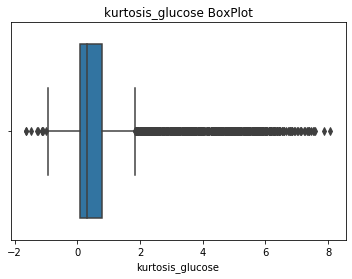

Skewness: 2.0397903192942093
Kurtosis: 3.326176069866889


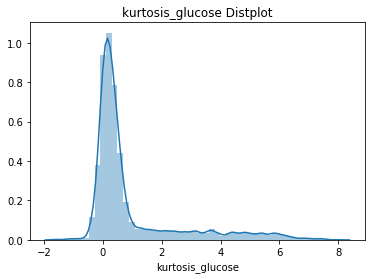



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


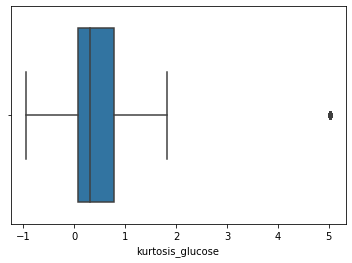

Skewness:  1.5615307321742697
Kurtosis: 0.637411008175603


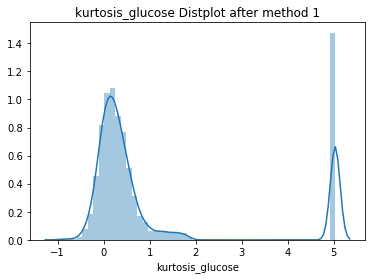



Metóda 2: Odstránenie odľahlých pozorovaní


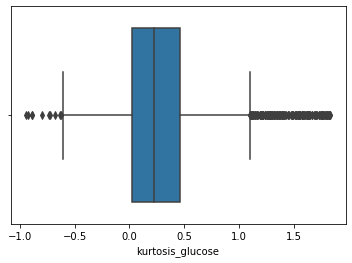

Skewness:  1.2370609315594336
Kurtosis: 2.4801078046373712


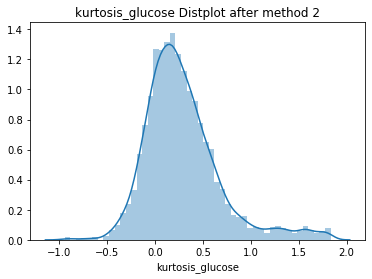

In [644]:
outlierCalculation('kurtosis_glucose')

Nahradenie maximálnej hodnoty pri outlieroch vyššou hodnotou, pretože výpočet nám povedal, že máme 700 outlierov, ale môžeme vidieť, že reálne dané hodnoty nemusia byť outliery. Posunuli sme hodnotu maxu o 6. Následne použijeme metódu 1 na finálnu úpravu. Napriek tomu, že po odstránení hodnôt(metóda 2) sa náš skewness priblížil najviac k nule, t.j rozloženie bolo viac rovnomerné, prišli by sme o dosť meraní, preto na ďalších atribútoch budeme pokračovať iba metódami 1 a 3.

In [645]:
minVKG,maxVKG = outlierCalculationWithValueShift('kurtosis_glucose',0,6)

Boxplot:
 * minimum value:  -0.9870843905000002 
 * maximum value:  7.838022517500001
Number of outliers:  12
Number of smaller values than min:  10
Number of higher values than max:  2


In [646]:
datasetProcessValues['kurtosis_glucose'][0] = getMinFromDataset(finalDataset,'kurtosis_glucose')
datasetProcessValues['kurtosis_glucose'][1] = minVKG
datasetProcessValues['kurtosis_glucose'][2] = maxVKG
datasetProcessValues['kurtosis_glucose'][3] = np.percentile(finalDataset['kurtosis_glucose'].dropna(),95)
datasetProcessValues['kurtosis_glucose'][4] = np.percentile(finalDataset['kurtosis_glucose'].dropna(),5)
datasetProcessValues['kurtosis_glucose'][5] = 1

In [647]:
datasetProcessValues

,field,kurtosis_glucose,kurtosis_oxygen,mean_glucose,mean_oxygen,skewness_glucose,skewness_oxygen,std_glucose,std_oxygen
0,minV,-1.64152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OutMin,-0.987084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OutMax,7.83802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95percentil,5.02818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5percentil,-0.191944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,methodNoOut,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [648]:
method1(finalDataset,'kurtosis_glucose',minVKG,maxVKG)

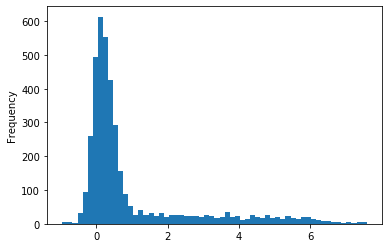

In [649]:
finalDataset['kurtosis_glucose'].plot.hist(bins = 60)

### kurtosis_oxygen

Boxplot:
 * minimum value:  -6.250789749999998 
 * maximum value:  20.169003273999998
Number of outliers:  51
Number of smaller values than min:  0
Number of higher values than max:  51


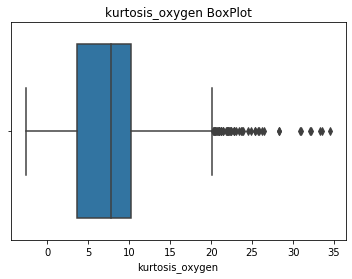

Skewness: 0.6006320158508656
Kurtosis: 1.4093556146687338


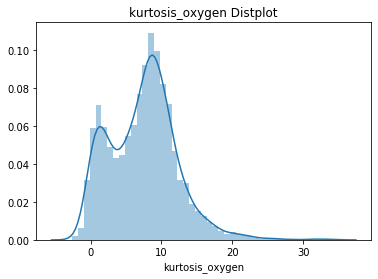



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


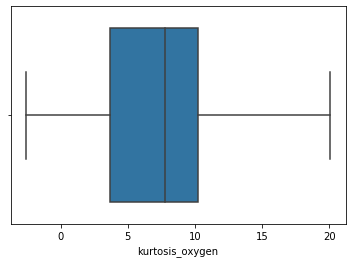

Skewness:  0.09930259483151563
Kurtosis: -0.5293089627855712


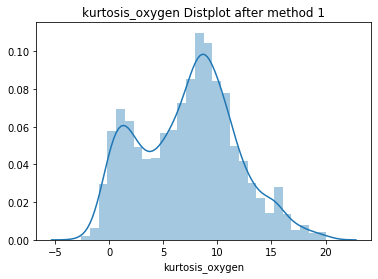



Metóda 2: Odstránenie odľahlých pozorovaní


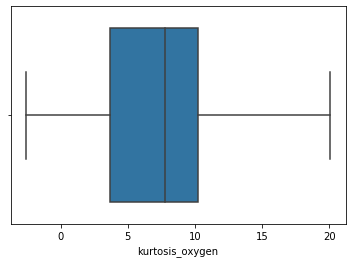

Skewness:  0.09930259483151563
Kurtosis: -0.5293089627855712


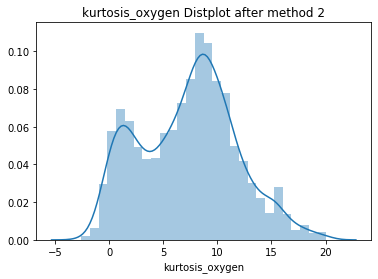

In [650]:
outlierCalculation('kurtosis_oxygen')

Podobne ako pri atribúte kurtosis_glucose, použijeme na úpravu outlierov metódu 1 s tým, že predtým posunieme hranicu maxu pri výpočte outlierov z 20 na 28.

In [651]:
minVKO,maxVKO = outlierCalculationWithValueShift('kurtosis_oxygen',0,8)

Boxplot:
 * minimum value:  -6.250789749999998 
 * maximum value:  28.169003273999998
Number of outliers:  9
Number of smaller values than min:  0
Number of higher values than max:  9


In [653]:
datasetProcessValues['kurtosis_oxygen'][0] = getMinFromDataset(finalDataset,'kurtosis_oxygen')
datasetProcessValues['kurtosis_oxygen'][1] = minVKO
datasetProcessValues['kurtosis_oxygen'][2] = maxVKO
datasetProcessValues['kurtosis_oxygen'][3] = np.percentile(finalDataset['kurtosis_oxygen'].dropna(),95)
datasetProcessValues['kurtosis_oxygen'][4] = np.percentile(finalDataset['kurtosis_oxygen'].dropna(),5)
datasetProcessValues['kurtosis_oxygen'][5] = 1

In [654]:
method1(finalDataset,'kurtosis_oxygen',minVKO,maxVKO)

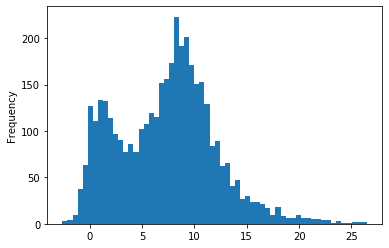

In [655]:
finalDataset['kurtosis_oxygen'].plot.hist(bins = 60)

### mean_glucose

Boxplot:
 * minimum value:  44.88671875 
 * maximum value:  169.48046875
Number of outliers:  364
Number of smaller values than min:  361
Number of higher values than max:  3


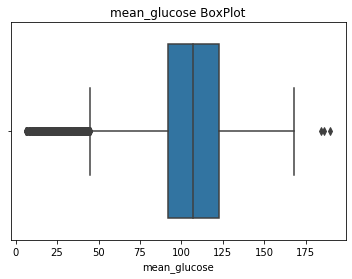

Skewness: -1.095297065302652
Kurtosis: 0.8025682827923837


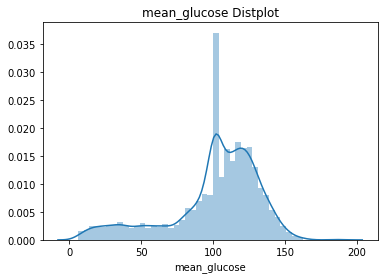



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


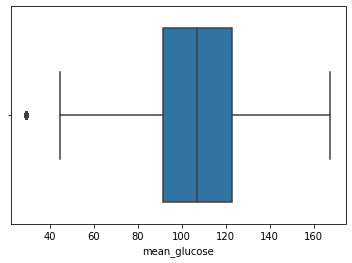

Skewness:  -1.0117785807497777
Kurtosis: 0.41515026524920806


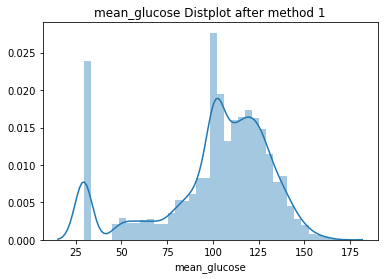



Metóda 2: Odstránenie odľahlých pozorovaní


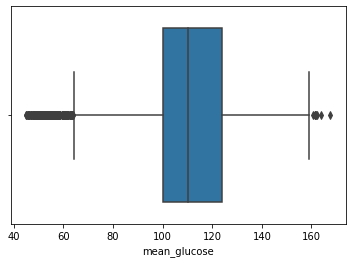

Skewness:  -0.6021054904681116
Kurtosis: 0.3897757728487621


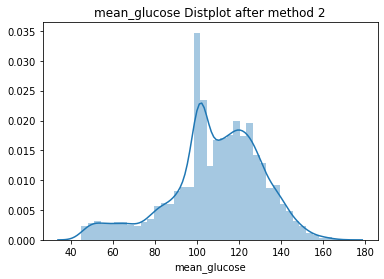



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


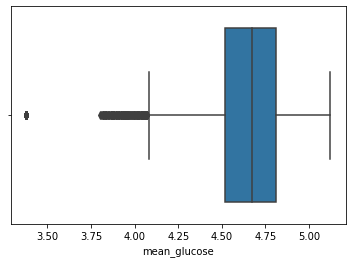

Skewness:  -1.7761052459991669
Kurtosis: 2.2274715412367105


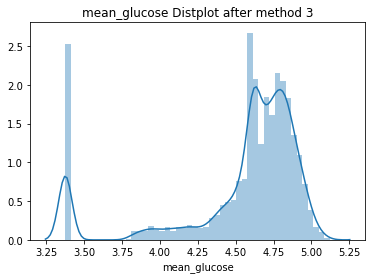

In [656]:
outlierCalculation('mean_glucose')

In [657]:
minVMG,maxVMG = outlierCalculationWithValueShift('mean_glucose',25,0)

Boxplot:
 * minimum value:  19.88671875 
 * maximum value:  169.48046875
Number of outliers:  115
Number of smaller values than min:  112
Number of higher values than max:  3


In [658]:
datasetProcessValues['mean_glucose'][0] = getMinFromDataset(finalDataset,'mean_glucose')
datasetProcessValues['mean_glucose'][1] = minVMG
datasetProcessValues['mean_glucose'][2] = maxVMG
datasetProcessValues['mean_glucose'][3] = np.percentile(finalDataset['mean_glucose'].dropna(),95)
datasetProcessValues['mean_glucose'][4] = np.percentile(finalDataset['mean_glucose'].dropna(),5)
datasetProcessValues['mean_glucose'][5] = 1

In [340]:
method3(finalDataset,'mean_glucose')

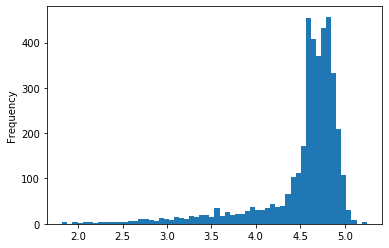

In [261]:
finalDataset['mean_glucose'].plot.hist(bins = 60)

In [341]:
outlierCalculationWithValueShift('mean_glucose',0,0)

Boxplot:
 * minimum value:  4.078346340700956 
 * maximum value:  5.2569087794425995
Number of outliers:  517
Number of smaller values than min:  517
Number of higher values than max:  0


(4.078346340700956, 5.2569087794425995)

Ako môžeme vidieť, logaritmovanie nepomohlo k zníženiu počtu outlierov a rozloženie dát vyzerá ešte menej symetrické, preto sa vrátime k metóde 1.

In [659]:
method1(finalDataset,'mean_glucose',minVMG,maxVMG)

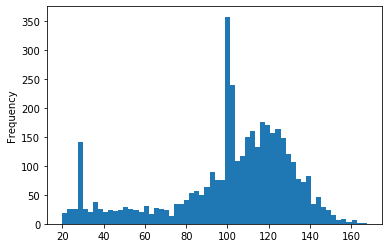

In [660]:
finalDataset['mean_glucose'].plot.hist(bins = 60)

### mean_oxygen

Boxplot:
 * minimum value:  -13.783862872499999 
 * maximum value:  28.4803511635
Number of outliers:  696
Number of smaller values than min:  0
Number of higher values than max:  696


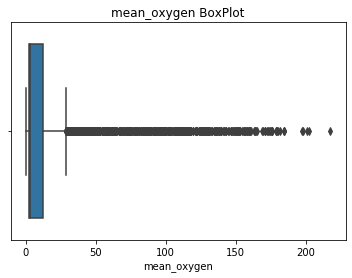

Skewness: 2.625286605478956
Kurtosis: 6.541540376958288


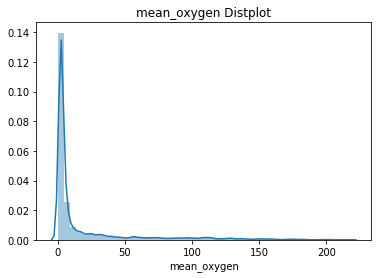



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


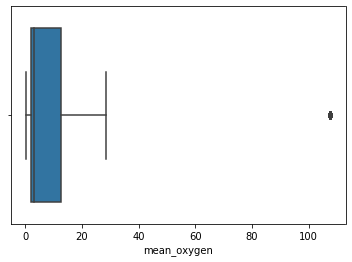

Skewness:  1.6397426813288398
Kurtosis: 0.76508455915907


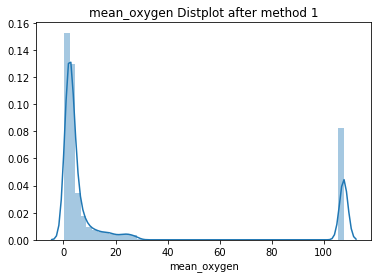



Metóda 2: Odstránenie odľahlých pozorovaní


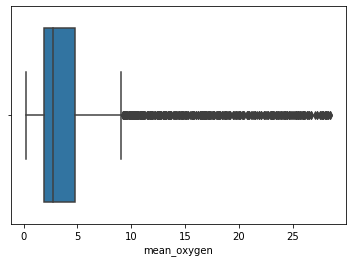

Skewness:  2.503051050063677
Kurtosis: 6.007310301082091


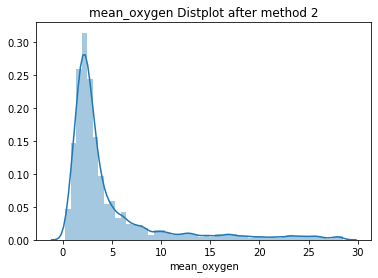



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


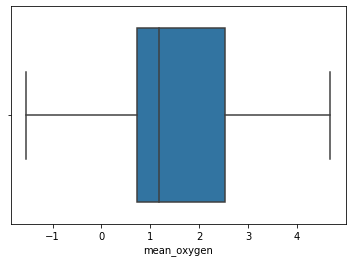

Skewness:  0.9172923267341347
Kurtosis: -0.42197092508470835


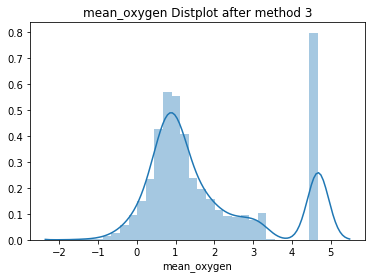

In [661]:
outlierCalculation('mean_oxygen')

Opätovne môžeme vidieť množstvo outlierov, ale keď sa na to pozrieme lepšie, vidíme, že sú rozmiestnení vcelku pravidelne, nie je to len jeden zhluk mimo ostatných, preto presunieme hranicu až o 150 pre maximálnu.

In [662]:
minVMO,maxVMO = outlierCalculationWithValueShift('mean_oxygen',0,150)

Boxplot:
 * minimum value:  -13.783862872499999 
 * maximum value:  178.4803511635
Number of outliers:  12
Number of smaller values than min:  0
Number of higher values than max:  12


In [663]:
datasetProcessValues['mean_oxygen'][0] = getMinFromDataset(finalDataset,'mean_oxygen')
datasetProcessValues['mean_oxygen'][1] = minVMO
datasetProcessValues['mean_oxygen'][2] = maxVMO
datasetProcessValues['mean_oxygen'][3] = np.percentile(finalDataset['mean_oxygen'].dropna(),95)
datasetProcessValues['mean_oxygen'][4] = np.percentile(finalDataset['mean_oxygen'].dropna(),5)
datasetProcessValues['mean_oxygen'][5] = 3

In [664]:
method3(finalDataset,'mean_oxygen')

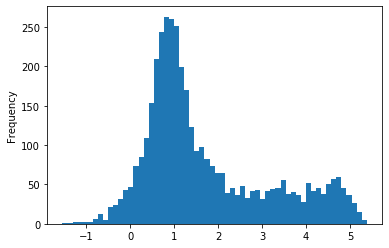

In [665]:
finalDataset['mean_oxygen'].plot.hist(bins = 60)

Pri použití logaritmovania vyzerajú dáta viac symetrické, čiže pre tento atribút použijeme danú metódu.

### skewness_glucose

Boxplot:
 * minimum value:  -3.4345080194999995 
 * maximum value:  5.4059226805
Number of outliers:  677
Number of smaller values than min:  0
Number of higher values than max:  677


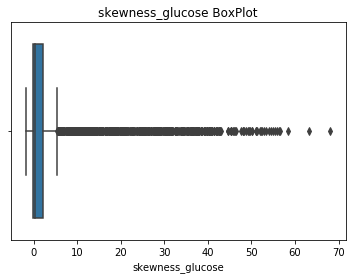

Skewness: 2.875531071068096
Kurtosis: 8.238833657500573


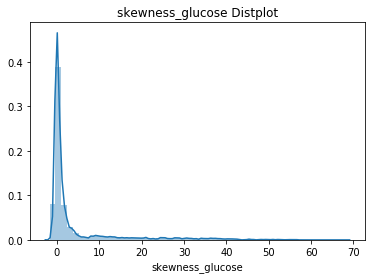



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


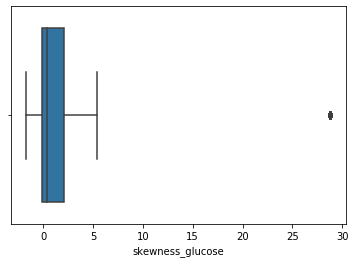

Skewness:  1.7039578550079286
Kurtosis: 0.9572215608842494


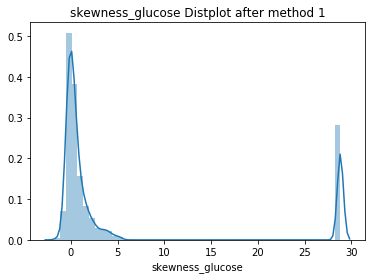



Metóda 2: Odstránenie odľahlých pozorovaní


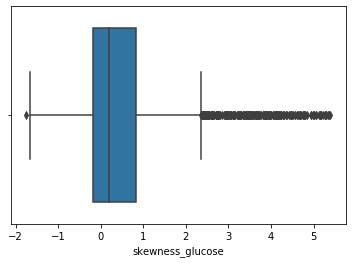

Skewness:  1.8047948644831115
Kurtosis: 3.470834329446007


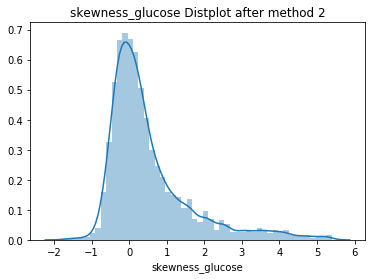

In [666]:
outlierCalculation('skewness_glucose')

Daný atribút má množstvo outlierov. Keďže rozdiel medzi horným kvartilom a niektorými je príliš veľký, skúsime najprv priamo nastaviť outlierov podľa percentilu 5/95 s tým, že hornú hranicu posunieme iba o 10.

In [667]:
minVSG,maxVSG = outlierCalculationWithValueShift('skewness_glucose',0,10)

Boxplot:
 * minimum value:  -3.4345080194999995 
 * maximum value:  15.4059226805
Number of outliers:  405
Number of smaller values than min:  0
Number of higher values than max:  405


In [668]:
datasetProcessValues['skewness_glucose'][0] = getMinFromDataset(finalDataset,'skewness_glucose')
datasetProcessValues['skewness_glucose'][1] = minVSG
datasetProcessValues['skewness_glucose'][2] = maxVSG
datasetProcessValues['skewness_glucose'][3] = np.percentile(finalDataset['skewness_glucose'].dropna(),95)
datasetProcessValues['skewness_glucose'][4] = np.percentile(finalDataset['skewness_glucose'].dropna(),5)
datasetProcessValues['skewness_glucose'][5] = 3

In [535]:
method1(finalDataset,'skewness_glucose',minVSG,maxVSG)

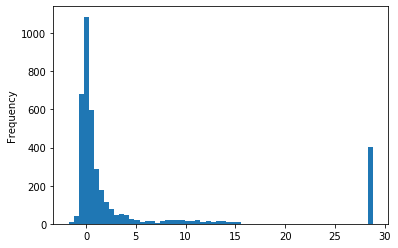

In [193]:
finalDataset['skewness_glucose'].plot.hist(bins = 60)

Toto nám nepríde ako dobrý výsledok a hranicu nechceme viac posúvať, preto skúsime najprv použiť metódu 3 - logaritmovanie.

In [669]:
method3(finalDataset,'skewness_glucose')

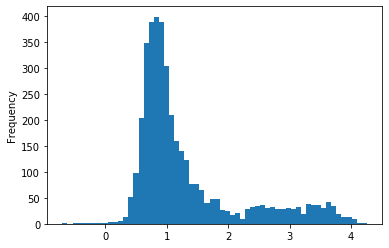

In [670]:
finalDataset['skewness_glucose'].plot.hist(bins = 60)

### skewness_oxygen

Boxplot:
 * minimum value:  -158.351309725 
 * maximum value:  298.22999319499996
Number of outliers:  163
Number of smaller values than min:  0
Number of higher values than max:  163


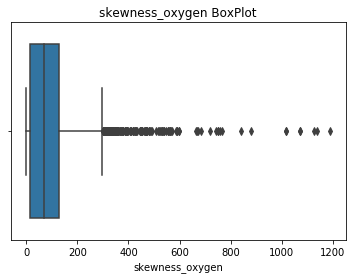

Skewness: 3.1837203295674725
Kurtosis: 18.410318740374397


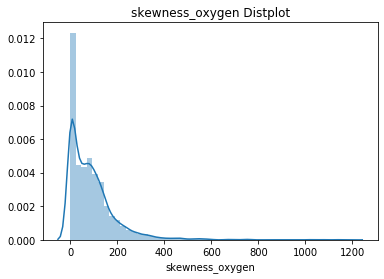



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


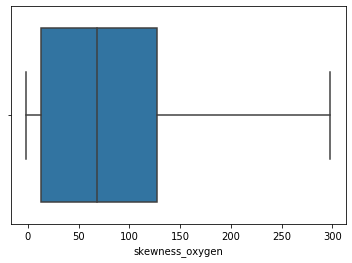

Skewness:  0.9460544073175468
Kurtosis: 0.09554459927754211


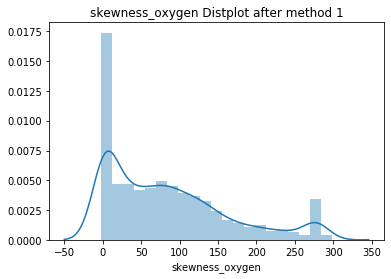



Metóda 2: Odstránenie odľahlých pozorovaní


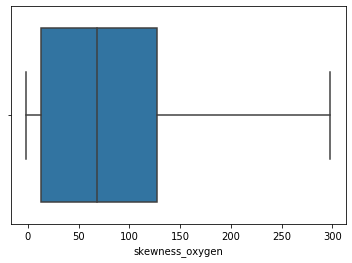

Skewness:  0.9460544073175468
Kurtosis: 0.09554459927754211


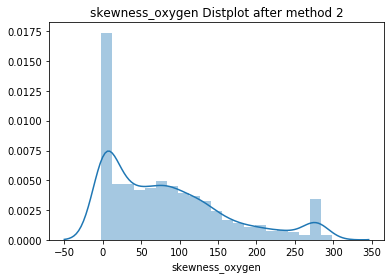

In [671]:
outlierCalculation('skewness_oxygen')

Daný atribút má outlierov vcelku rozhádzaných, skúsime najprv použiť metódu logaritmovania.

In [672]:
minVSO,maxVSO = outlierCalculationWithValueShift('skewness_oxygen',0,0)

Boxplot:
 * minimum value:  -158.351309725 
 * maximum value:  298.22999319499996
Number of outliers:  163
Number of smaller values than min:  0
Number of higher values than max:  163


In [673]:
datasetProcessValues['skewness_oxygen'][0] = getMinFromDataset(finalDataset,'skewness_oxygen')
datasetProcessValues['skewness_oxygen'][1] = minVSO
datasetProcessValues['skewness_oxygen'][2] = maxVSO
datasetProcessValues['skewness_oxygen'][3] = np.percentile(finalDataset['skewness_oxygen'].dropna(),95)
datasetProcessValues['skewness_oxygen'][4] = np.percentile(finalDataset['skewness_oxygen'].dropna(),5)
datasetProcessValues['skewness_oxygen'][5] = 3

In [674]:
method3(finalDataset,'skewness_oxygen')

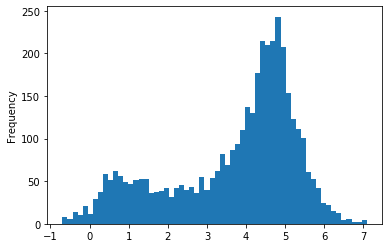

In [675]:
finalDataset['skewness_oxygen'].plot.hist(bins = 60)

### std_glucose

Boxplot:
 * minimum value:  24.860714829999992 
 * maximum value:  65.67407923
Number of outliers:  20
Number of smaller values than min:  0
Number of higher values than max:  20


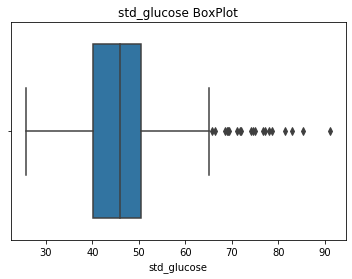

Skewness: 0.027756941125541675
Kurtosis: 0.8036567973355315


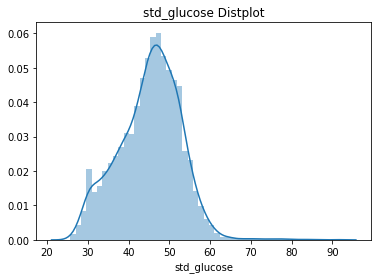



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


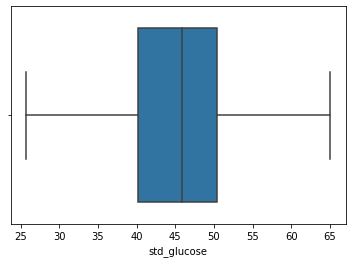

Skewness:  -0.3039688700157517
Kurtosis: -0.4109932332959456


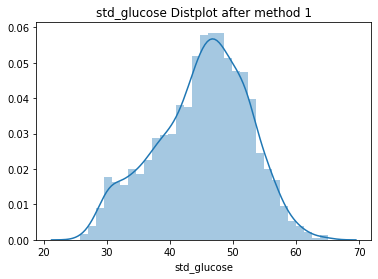



Metóda 2: Odstránenie odľahlých pozorovaní


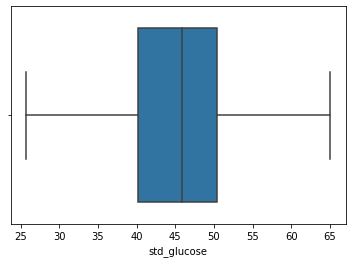

Skewness:  -0.3039688700157517
Kurtosis: -0.4109932332959456


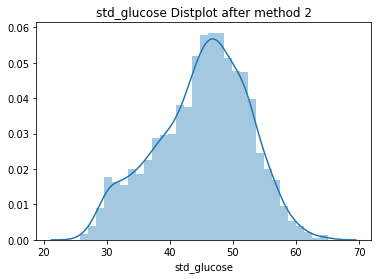



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


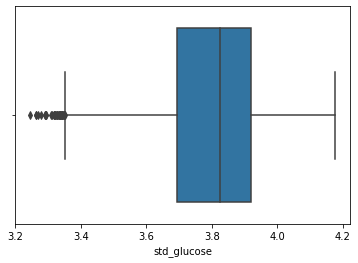

Skewness:  -0.6850830365355961
Kurtosis: -0.035201568402996486


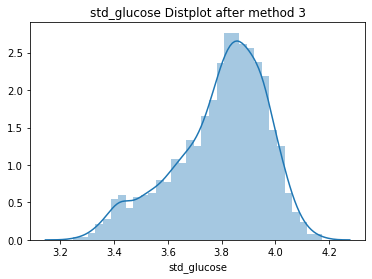

In [676]:
outlierCalculation('std_glucose')

Daný atribút nemá veľa outlierov a keď sa na to pozrieme, hodnoty nevyzerajú byť až tak vzdialené od prípustných, preto iba posunieme hranicu maximálnej prípustnej hodnoty asi na 80 a na zvyšný počet outlierov použijeme metódu 1.

In [677]:
minVSTG,maxVSTG = outlierCalculationWithValueShift('std_glucose',0,15)

Boxplot:
 * minimum value:  24.860714829999992 
 * maximum value:  80.67407923
Number of outliers:  4
Number of smaller values than min:  0
Number of higher values than max:  4


In [678]:
datasetProcessValues['std_glucose'][0] = getMinFromDataset(finalDataset,'std_glucose')
datasetProcessValues['std_glucose'][1] = minVSTG
datasetProcessValues['std_glucose'][2] = maxVSTG
datasetProcessValues['std_glucose'][3] = np.percentile(finalDataset['std_glucose'].dropna(),95)
datasetProcessValues['std_glucose'][4] = np.percentile(finalDataset['std_glucose'].dropna(),5)
datasetProcessValues['std_glucose'][5] = 1

In [679]:
method1(finalDataset,'std_glucose',minVSTG,maxVSTG)

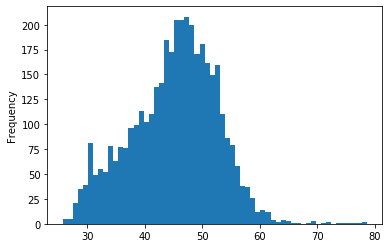

In [680]:
finalDataset['std_glucose'].plot.hist(bins = 60)

### std_oxygen

Boxplot:
 * minimum value:  -27.230313685000002 
 * maximum value:  85.492348115
Number of outliers:  81
Number of smaller values than min:  0
Number of higher values than max:  81


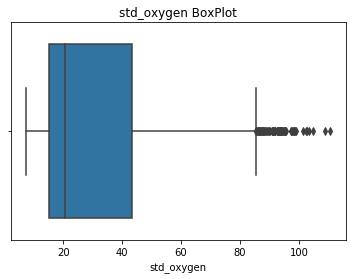

Skewness: 1.2013609024984617
Kurtosis: 0.22590521544548903


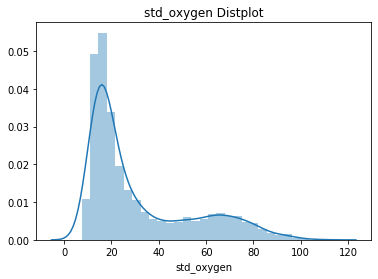



Metóda 1: Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)


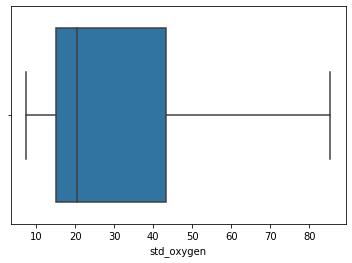

Skewness:  1.0979629283252954
Kurtosis: -0.20073858111137133


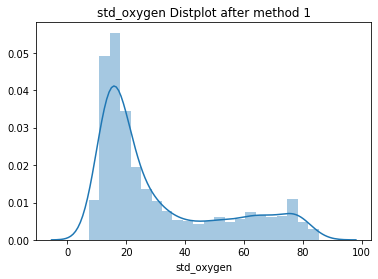



Metóda 2: Odstránenie odľahlých pozorovaní


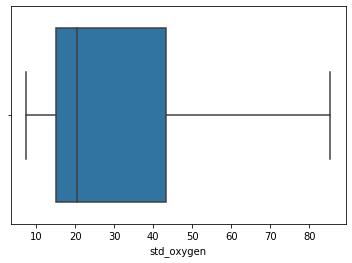

Skewness:  1.0979629283252954
Kurtosis: -0.20073858111137133


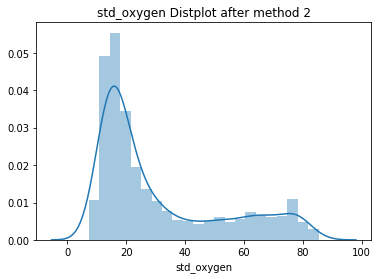



Metóda 3: Transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.


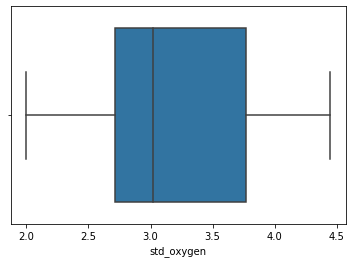

Skewness:  0.516954969192208
Kurtosis: -1.0221805811625346


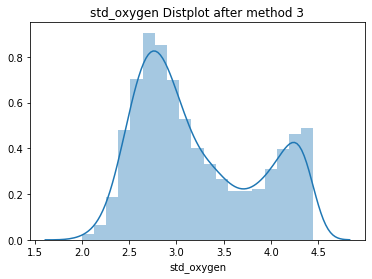

In [681]:
outlierCalculation('std_oxygen')

Podobne ako pri std_glucose, použijeme metódu 1, aj keď je počet outlierov o čosi vyšší, stále to vyzerá na prípustné hodnoty. Maximálnu hranicu posunieme asi na hodnotu 100.

In [682]:
minVSTO,maxVSTO= outlierCalculationWithValueShift('std_oxygen',0,15)

Boxplot:
 * minimum value:  -27.230313685000002 
 * maximum value:  100.492348115
Number of outliers:  7
Number of smaller values than min:  0
Number of higher values than max:  7


In [683]:
datasetProcessValues['std_oxygen'][0] = getMinFromDataset(finalDataset,'std_oxygen')
datasetProcessValues['std_oxygen'][1] = minVSTO
datasetProcessValues['std_oxygen'][2] = maxVSTO
datasetProcessValues['std_oxygen'][3] = np.percentile(finalDataset['std_oxygen'].dropna(),95)
datasetProcessValues['std_oxygen'][4] = np.percentile(finalDataset['std_oxygen'].dropna(),5)
datasetProcessValues['std_oxygen'][5] = 1

In [684]:
method1(finalDataset,'std_oxygen',minVSTO,maxVSTO)

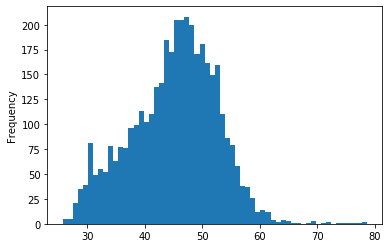

In [685]:
finalDataset['std_glucose'].plot.hist(bins = 60)

In [686]:
datasetProcessValues

,field,kurtosis_glucose,kurtosis_oxygen,mean_glucose,mean_oxygen,skewness_glucose,skewness_oxygen,std_glucose,std_oxygen
0,minV,-1.64152,-2.59787,6.1875,0.213211,-1.75533,-1.97698,25.6952,7.37043
1,OutMin,-0.987084,-6.25079,19.8867,-13.7839,-3.43451,-158.351,24.8607,-27.2303
2,OutMax,7.83802,28.169,169.48,178.48,15.4059,298.23,80.6741,100.492
3,95percentil,5.02818,15.2408,139.889,107.69,28.8133,277.17,56.1858,77.8075
4,5percentil,-0.191944,0.20282,29.2797,1.05836,-0.526402,-0.870594,31.1723,11.3336
5,methodNoOut,1,1,1,3,3,3,1,1


## Znovupoužiteľnosť

Nasledujúce funkcie sme vytvorili z vyššie používaných funkcií, aby sa jednoducho dali používať aj pre iné datasety.

Funkcia na spojenie datasetov:

In [688]:
def mergeDatasets(dataset1,dataset2):
    mergedDataset = pd.merge(dataset1,dataset2, on=['name','address'], how='left')
    duplicates = mergedDataset[mergedDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
    mergedDataset = mergedDataset.drop_duplicates(['name', 'address'], keep=False)
    names = duplicates.name.unique()

    for name in names:
        tmp = duplicates[duplicates['name'] == name]
        tmp = tmp.fillna(method='ffill')
        tmp = tmp.fillna(method='bfill')
        tmp = tmp.drop_duplicates(['name'])
        mergedDataset = mergedDataset.append(tmp, ignore_index=True)
    return mergedDataset

In [482]:
mergedDataset = mergeDatasets(other_valid,personal_valid)

Funkcia na opravenie údajov:

In [503]:
def dataFixing(dataset):
    dataset['date_of_birth'] = dataset['date_of_birth'].apply(changeDate)
    dataset['pregnant'] = dataset['pregnant'].apply(changePregnantInfoFlag)
    dataset['address'] = dataset['address'].apply(addressCorrection)
    dataset[['job','state','family_status','home','color']] = dataset['personal_info'].apply(process_pi)
    del dataset['personal_info']
    dataset['sex'] = dataset['sex'].apply(fixSex)
    dataset.loc[(dataset["sex"] == 'Male') & (dataset["pregnant"] == 't') , 'pregnant'] = 'f'
    dataset['capital'] = dataset['capital-gain'] - dataset['capital-loss']
    dataset['age'] = dataset['age'].apply(repair_age)
    del dataset["capital-gain"]
    del dataset["capital-loss"]

Funkcia na doplnenie chýbajúcich údajov:

In [504]:
def missingDataProcessing(dataset):
    setMissingValuesToMean(dataset,'kurtosis_oxygen')
    setMissingValuesToMean(dataset,'skewness_glucose')
    setMissingValuesToSegmentMean(dataset,'mean_glucose')
    setMissingValuesToMean(dataset,'kurtosis_glucose')
    setMissingValuesToMedian(dataset,'fnlwgt')
    setMissingValueToUndefined(dataset,'income')
    setMissingValueToUndefined(dataset,'capital')

Funkcia na úpravu vychýlených hodnôt:

In [485]:
def outlierProcessing(dataset):
    method1(dataset,'kurtosis_glucose',datasetProcessValues['kurtosis_glucose'][1],datasetProcessValues['kurtosis_glucose'][2])
    method1(dataset,'kurtosis_oxygen',datasetProcessValues['kurtosis_oxygen'][1],datasetProcessValues['kurtosis_oxygen'][2])
    method1(dataset,'mean_glucose',datasetProcessValues['mean_glucose'][1],datasetProcessValues['mean_glucose'][2])    
    method3(dataset,'mean_oxygen')
    method3(dataset,'skewness_glucose')
    method3(dataset,'skewness_oxygen')
    method1(dataset,'std_glucose',datasetProcessValues['std_glucose'][1],datasetProcessValues['std_glucose'][2])
    method1(dataset,'std_oxygen',datasetProcessValues['std_oxygen'][1],datasetProcessValues['std_oxygen'][2])

Funkcia, ktorá spojí datasety a upraví výsledný dataset:

In [486]:
def finalFunction(dataset1,dataset2):
    mergedDataset = mergeDatasets(dataset1,dataset2)
    dataFixing(mergedDataset)
    missingDataProcessing(mergedDataset)
    outlierProcessing(mergedDataset)
    return mergedDataset

## Opätovná prieskumná analýza

In [838]:
finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 27 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3933 non-null float64
pregnant            3933 non-null object
education-num       3933 non-null float64
relationship        3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3933 non-null float64
std_oxygen          3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3933 non-null float64
income              3933 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
age                 3933 non-null int64
sex                 3933 non-null object
date_of_birth       3933 non-null object
capital             3

Datasety personal_train a other_train sme spojili do jedného datasetu finalDataset. Nový dataset obsahuje 27 atribútov a 3933 záznamov. Chýbajúce a nezmyselné hodnoty sú opravené. Pozrieme sa na dôležité atribúty, ktorých hodnoty prešli úpravami.

In [839]:
finalDataset.describe(include = np.number)

,kurtosis_oxygen,education-num,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,mean_oxygen,hours-per-week,age
count,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3.933000e+03,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000
mean,7.342734,10.087719,1.319470,101.560923,30.987012,3.701051,0.950213,1.906251e+05,0.255276,45.119650,1.707456,40.664887,51.817188
std,4.682211,2.611245,0.877276,30.694161,22.063744,1.625956,1.600305,1.040754e+05,0.436072,7.511716,1.427141,12.187793,11.813677
min,-2.597872,1.000000,-0.693147,19.960938,7.370432,-0.693147,-0.944764,1.941000e+04,0.000000,25.695250,-1.545474,1.000000,0.000000
25%,3.608318,9.000000,0.758928,91.570312,15.012952,2.730702,0.071569,1.181080e+05,0.000000,40.140719,0.725235,40.000000,44.000000
50%,7.751764,10.000000,0.967295,106.945312,20.503977,4.262221,0.310372,1.809850e+05,0.000000,45.852278,1.174530,40.000000,52.000000
75%,10.231310,13.000000,1.469277,122.734375,42.836732,4.863596,0.775684,2.384330e+05,1.000000,50.337673,2.536176,45.000000,60.000000
max,26.461846,16.000000,4.253582,167.593750,99.110968,7.084627,7.572577,1.268339e+06,1.000000,78.619808,5.381607,99.000000,113.000000


In [840]:
finalDataset.describe(exclude = np.number)

,name,address,pregnant,relationship,education,income,sex,date_of_birth,capital,job,state,family_status,home,color
count,3933,3933,3933,3933,3933,3933,3933,3933,3933.0,3933,3933,3933,3933,3933
unique,3933,3933,2,6,24,3,2,3469,123.0,16,38,8,12,6
top,Steven Arnold,"2145 Jones Mill New Robertobury, KY 03704",f,Husband,HS-grad,<=50K,Male,1963-02-12,0.0,Prof-specialty,United-States,Married-civ-spouse,Private,White
freq,1,1,3863,1605,1108,2988,2646,5,3420.0,488,3512,1800,2476,3371


### name

V datasete sú odstránené duplikáty.

In [690]:
finalDataset["name"].describe()

count              3933
unique             3933
top       Steven Arnold
freq                  1
Name: name, dtype: object

### age

Pre vek sme upravili nezmyselné hodnoty. Koeficient asymetrie je -0,12, čiže rozdelenie grafu je normálne.

In [710]:
finalDataset["age"].skew()

-0.1185302791787588

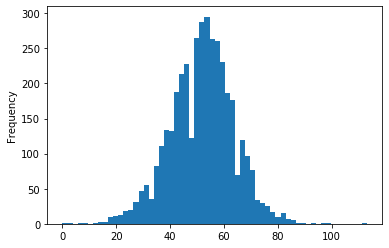

In [691]:
finalDataset["age"].plot.hist(bins=60)

### date_of_birth

Formáty dátumov v datasete boli rôzne. Upravili sme ich na jeden spoločný formát yyyy-mm-dd.

In [712]:
finalDataset['date_of_birth'].str.replace('[0-9]', '0').value_counts()

0000-00-00    3933
Name: date_of_birth, dtype: int64

### pregnant

Pre atribút pregnant bolo taktiež viacero rôznych formátov hodnôt true a false. Upravili sme ich na jeden spoločný formát t/f. Okrem toho sme u každého muža, ktorý mal atribút pregnant nastavený na true, prepísali hodnotu na false.

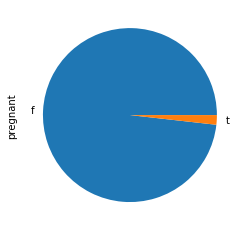

In [692]:
finalDataset['pregnant'].value_counts().plot(kind='pie')

In [693]:
finalDataset['pregnant'].value_counts()

f    3863
t      70
Name: pregnant, dtype: int64

### kurtosis_oxygen

Koeficient asymetrie bol pred úpravou tohto atribútu okolo 0,6, teraz je takmer 0,37, čo znamená, že sme sa o trochu viac priblížili normálnemu rozdeleniu.

In [696]:
finalDataset["kurtosis_oxygen"].skew()

0.3686881175169879

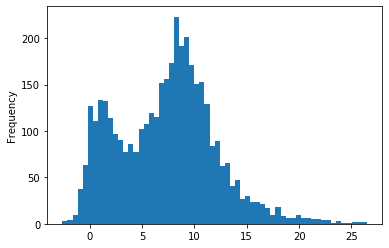

In [697]:
finalDataset["kurtosis_oxygen"].plot.hist(bins=60)

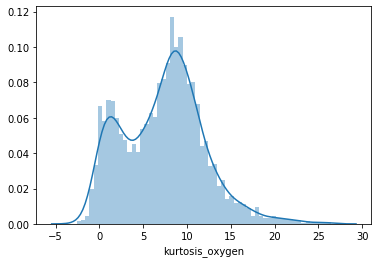

In [739]:
sb.distplot(finalDataset["kurtosis_oxygen"].dropna(), bins=60)

### mean_oxygen

Koeficient asymetrie mal pred úpravou tohto atribútu hodnotu takmer 2,64, po úprave má hodnotu 0,9, značne sme sa teda priblížili normálnemu rozdeleniu. Veľký rozdiel je aj v koeficiente špicatosti, pretože pred úpravou mal tento koeficient hodnotu 6,62 a po úprave má -0,24.

In [723]:
finalDataset["mean_oxygen"].skew()

0.8957908948829328

In [724]:
finalDataset["mean_oxygen"].kurtosis()

-0.23913499469025412

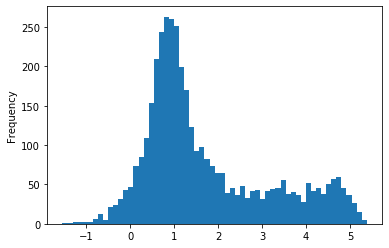

In [725]:
finalDataset["mean_oxygen"].plot.hist(bins=60)

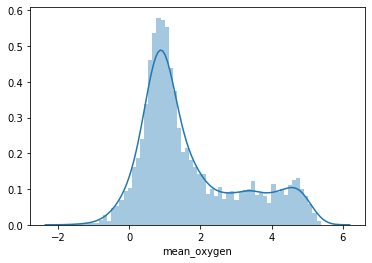

In [738]:
sb.distplot(finalDataset["mean_oxygen"].dropna(), bins=60)

### skewness_glucose

Koeficient asymetrie mal pred úpravou tohto atribútu hodnotu 2,88, po úprave má hodnotu 1,52, trochu sme sa priblížili normálnemu rozdeleniu, ale stále je viac naklonený doľava. Veľký rozdiel je hlavne v koeficiente špicatosti, pretože pred úpravou mal tento koeficient hodnotu 8,31 a po úprave má 1,29.

In [702]:
finalDataset["skewness_glucose"].skew()

1.5204373972261935

In [726]:
finalDataset["skewness_glucose"].kurtosis()

1.289429950422226

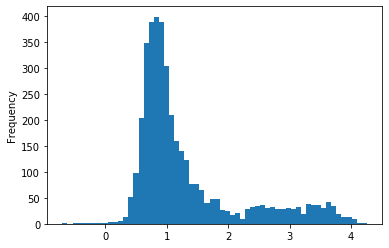

In [703]:
finalDataset["skewness_glucose"].plot.hist(bins=60)

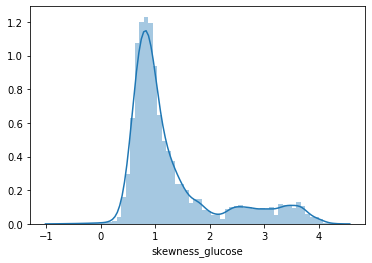

In [737]:
sb.distplot(finalDataset["skewness_glucose"].dropna(), bins=60)

### skewness_oxygen

Koeficient asymetrie mal pred úpravou tohto atribútu hodnotu 3,17, po úprave má hodnotu -0,82, sme teda bližšie normálnemu rozdeleniu. Pred úpravou bol teda naklonený viac doľava, teraz je to však viac doprava. Extrémny rozdiel je v koeficiente špicatosti, pred úpravou mal tento koeficient hodnotu 18,28 a po úprave má -0,35.

In [704]:
finalDataset["skewness_oxygen"].skew()

-0.8179032486729542

In [727]:
finalDataset["skewness_oxygen"].kurtosis()

-0.3468333978637479

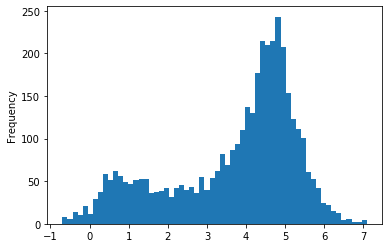

In [705]:
finalDataset["skewness_oxygen"].plot.hist(bins=60)

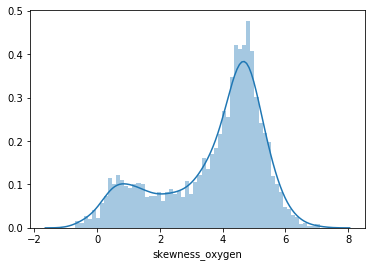

In [736]:
sb.distplot(finalDataset["skewness_oxygen"].dropna(), bins=60)

Atribúty std_oxygen, std_glucose, mean_glucose, kurtosis_glucose, ktoré boli taktiež upravované, sa po úprave priveľmi neodlišovali od ich stavu pred úpravou.

### .csv súbor

Nakoniec prevedieme upravený dataframe do súboru s formátom csv.

In [841]:
finalDataset.to_csv(index=False)

'name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,education,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,age,sex,date_of_birth,capital,job,state,family_status,home,color\r\nBrian Newhall,"52925 Barton Ville Suite 664 East Whitney, DC 94830",8.289888515,f,14.0, Not-in-family,0.6293420853331588,119.4453125,17.929756899999994,4.428713304394506,0.012830273, Masters,192702.0,0.0,53.14305702, <=50K,1.0757783154619365,50.0,69,Female,1950-06-08,0.0,Craft-repair,United-States,Never-married,Private,White\r\nPatrick Behne,"037 Long Springs Port Maria, OH 58969",4.322443603,f,6.0, Husband,1.8565603276709362,77.0859375,43.98006106,3.0124522269857907,1.620462497, 10th,211116.0,1.0,43.39193246, <=50K,2.3604910909344636,40.0,59,Male,1960-07-28,0.0,Other-service,United-States,Married-civ-spouse,Private,Black\r\nSteven Arnold,"471 Kevin Spurs Suite 564 Reneeland, NC 84482",4.702129693,f,5.0, Own-child